In [60]:
# SETUP
# data_file_path = 'data/production/autotrader.csv'
data_file_path = 'data/legacy/cleaned_auto_trader_data_aston_martin.csv'
model_choice = 'rf' # 'rf'
filter_max_value = 0.15*1e6
filter_index_str = str(int(filter_max_value/1e3))
feature_engineer = False
retrain = False
fe_str = 'fe' if feature_engineer else ''
model_path = f'artifacts/filtered/{filter_index_str}/{fe_str}'

print(model_path)


artifacts/filtered/150/


In [61]:
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# PREPROCESS



# Load the data
print("Loading data...")
data = pd.read_csv(data_file_path)

# Preprocess numeric columns
print("Preprocessing numeric columns...")
for col in ['Price', 'Mileage', 'Year', 'Prior_Owners']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    # data[col].fillna(data[col].mean(), inplace=True)

# Filter the data
print("BEFORE FILTER:",len(data))
data = data[data['Price'] <= filter_max_value] #! filtering
print("AFTER FILTER:",len(data))

# Create the pair plot
numeric_features_to_plot = ['Mileage', 'Year', 'Prior_Owners', 'Price']

# Function to extract numeric part from a string (for 'Price' and 'Mileage')
def extract_numeric(value):
    try:
        # Remove non-digit characters, preserve decimal points and negative signs
        numeric_string = re.sub("[^-0-9.]", "", str(value))
        return float(numeric_string)
    except ValueError:
        return np.nan  # Return NaN for non-numeric or empty values
    
    

# Clean the 'Year' column by removing parentheses and their contents
data['Year'] = data['Year'].astype(str).apply(lambda x: re.sub(r'\s*\(.*\)', '', x)).astype(float)

# Apply transformations and validations
data['Price'] = data['Price'].apply(extract_numeric)
data['Mileage'] = data['Mileage'].apply(extract_numeric)
data['Prior_Owners'] = data['Prior_Owners'].apply(extract_numeric)  # Updated to use extract_numeric
data['Engine_Size'] = data['Engine_Size'].apply(extract_numeric)

data = data[data['Engine_Size'] <= 10] # remove anomaly




# Fill in missing data with 'Unknown' for other categorical columns
categorical_columns = ['Model', 'Additional_Comments', 'Car_Type', 'Engine_Type', 'Dealership_Location', 'Sale_Type']
data[categorical_columns] = data[categorical_columns].fillna('Unknown')

# Remove rows with 'Unknown' values in critical columns
data = data[data['Price'] != 'Unknown']
data = data[data['Mileage'] != 'Unknown']
data = data[data['Year'] != 'Unknown']
data = data[data['Engine_Size'] != 'Unknown']


# Adding the delete duplicates feature
cleaned_data = data.drop_duplicates()

Loading data...
Preprocessing numeric columns...
BEFORE FILTER: 1049
AFTER FILTER: 904


In [62]:
# # EXPLORATORY DATA ANALYSIS

# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming your dataset is loaded into a DataFrame named df
# # df = pd.read_csv('your_dataset.csv')

# # Example: Visualizing the relationship between Mileage and Price for different Car Types
# sns.scatterplot(data=data, x='Mileage', y='Price', hue='Car_Type')
# plt.title('Price vs. Mileage by Car Type')
# plt.show()

# # Assuming 'df' is your DataFrame with 'car_type' and 'price' columns


# # Boxplot to visualize the distribution of prices for each car type
# plt.figure(figsize=(12, 8))
# sns.boxplot(x='Car_Type', y='Price', data=data)
# plt.title('Price Distribution by Car Type')
# plt.xticks(rotation=45)
# plt.show()

# # Plotting Make and Year vs Price
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Year', y='Price', hue='Make', data=data)
# plt.title('Price by Year and Make')
# plt.show()

# # Plotting Mileage and Year vs Price
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Year', y='Price', hue='Mileage', palette="coolwarm", data=data)
# plt.title('Price by Year and Mileage')
# plt.show()

In [63]:
# FEATURE ENGINEERING

if feature_engineer:
    # Interaction terms
    data['Make_Year'] = data['Make'] + '_' + data['Year'].astype(str)
    data['Mileage_Year'] = data['Mileage'] * data['Year']
    data['EngineSize_CarType'] = data['Engine_Size'].astype(str) + '_' + data['Car_Type']
    data['Transmission_EngineType'] = data['Transmission'] + '_' + data['Engine_Type']

    # Encode categorical variables if you haven't already
    data = pd.get_dummies(data, drop_first=True, columns=['Make_Year', 'Mileage_Year', 'EngineSize_CarType', 'Transmission_EngineType'])

    data.head()


In [64]:
# For Aston_Martin - Extended Data

from datetime import datetime
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
import joblib



# Preprocess numeric columns
print("Preprocessing numeric columns...")
for col in ['Price', 'Mileage', 'Year', 'Prior_Owners']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col].fillna(data[col].mean(), inplace=True)

# Preprocessing pipelines
print("Creating preprocessing pipelines...") # TODO visualise the data after and before preprocessing to see if any issues with it
numeric_features = ['Mileage', 'Year', 'Prior_Owners']
numeric_transformer = StandardScaler()

categorical_features = ['Make', 'Car_Type', 'Sale_Type']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# TF-IDF Vectorizer for 'Model' column
print("Applying TF-IDF Vectorization...") # TODO check results of this vectorisation. not sure TF-IDF is needed for "Model" of car tbh but interesting.
tfidf_vectorizer = TfidfVectorizer(max_features=2500)
X_tfidf = tfidf_vectorizer.fit_transform(data['Model'])

# Fit and transform the data using the preprocessor
X_preprocessed = preprocessor.fit_transform(data.drop('Model', axis=1)) # TODO check the data here is not a concatination, but just the preprocessed data 

# Combine TF-IDF features with preprocessed numeric and categorical features # TODO investigate how this data looks, both TFIDF and preprocessed, to see if we really can expect model to fit to both at same time
X_combined = np.hstack((X_tfidf.toarray(), X_preprocessed if isinstance(X_preprocessed, np.ndarray) else X_preprocessed.toarray()))
# TODO I think bunching this data together and using random forest isn't a good combination. Need to visualise both the TFIDF data and preprocessed data, seperately, and both before and after preprocessing. Do some exploratory data analysis. Visualise words with word map (bigger words for more frequent) and visualise numeric data with grid map different variables on each axis of grid

# Split the data
print("Splitting data...")
y = data['Price'].values
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

print("DONE")
print("DATASET SIZE:",len(y))

Preprocessing numeric columns...
Creating preprocessing pipelines...
Applying TF-IDF Vectorization...
Splitting data...
DONE
DATASET SIZE: 894


/var/folders/1f/kh62j3491pg82ts5mywnf4hc0000gn/T/ipykernel_51619/1820685514.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


In [65]:
if retrain:
    # Model Training with Hyperparameter Tuning
    print("Training model with hyperparameter tuning...")
    rf_model = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [20, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(rf_model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Use the best estimator # TODO investigate the "performance" of each model with different hyperparamter tuning. Check it's actually finding a good one, not just the least poor performing.
    best_rf_model = grid_search.best_estimator_
    print("Best model found:", best_rf_model)

    # Predictions and Evaluation
    print("Making predictions and evaluating...")
    y_pred = best_rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)

    # Output the model performance
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')  
    print(f'R2 Score: {r2}') # TODO this score seems good. but not great. Investigate examples where it's accurate, and where it's messing up. see if there's anything obvious. back to EDA


    # Save the model, vectorizer, and preprocessor
    print("Saving model, vectorizer, and preprocessor...")
    joblib.dump(best_rf_model, f'{model_path}random_forest_car_price_predictor.joblib')
    joblib.dump(tfidf_vectorizer, f'{model_path}tfidf_vectorizer.joblib')
    joblib.dump(preprocessor, f'{model_path}preprocessor.joblib')

    print("Process completed.")

In [66]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

if retrain:
    print("Training XGBoost model")

    # Switch to XGBRegressor
    xgb_model = XGBRegressor(random_state=42)

    # Adjusting the param_grid for XGBoost-specific hyperparameters
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [6, 10, 15],  # XGBoost often uses smaller depths
        'learning_rate': [0.01, 0.1, 0.2],  # Also known as eta
        'subsample': [0.8, 1],  # Subsample ratio of the training instances
        'colsample_bytree': [0.8, 1],  # Subsample ratio of columns when constructing each tree
    }

    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Use the best estimator
    best_xgb_model = grid_search.best_estimator_
    print("Best model found:", best_xgb_model)

    # Predictions and Evaluation
    print("Making predictions and evaluating...")
    y_pred = best_xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Output the model performance
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R2 Score: {r2}')

    # Save the model, and potentially other artifacts if they are part of your workflow
    print("Saving model...")
    joblib.dump(best_xgb_model, f'{model_path}xgboost_car_price_predictor.joblib')

    print("Process completed.")


In [67]:
import joblib

# Load the saved model
xgb_model = joblib.load(f'{model_path}/xgboost_car_price_predictor.joblib')
rf_model = joblib.load(f'{model_path}/random_forest_car_price_predictor.joblib')
models = {'xgb':xgb_model, 'rf': rf_model}
print("Models loaded successfully.")


# Make predictions with the loaded model
model = models[model_choice]
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Predictions made on new data:", y_pred)

# Now you can use y_pred_new as needed for your application


Models loaded successfully.
Predictions made on new data: [ 77626.95969246  50842.6873869   55729.53989881  68252.03277976
  44967.54800866  35629.77081818  34358.64144444 113920.74390963
  76906.93575     36181.59952381  32451.79809524 114392.47284127
  32451.79809524  58117.17530988 136384.13894841  36947.1976627
  52344.65429594 112731.04483279  88763.22849802  89122.3070496
  65990.          67983.94631746  26460.34645833  57735.09044841
  84218.4983741  128675.8387031   40238.52839286  96674.84351984
  37110.5860285   34885.88576389  81601.12730556  28804.40200216
  35145.95013835  78733.74271501 102664.4604715   64995.695
  42465.31954563 124655.89468254  42612.79041631 114939.09956349
  34328.31123413  29386.89455088  65432.12082341  40238.52839286
  78197.95509722  38849.28479563  75088.17063348 112875.35287103
  68254.24289881  84677.80243525  44944.86169805  39709.60642731
  60836.68680052  70407.67719643  64527.17904672 115865.24851876
 141091.86436995  45743.43262302  37543

In [68]:
# DIVING INTO INFERENCE ACCURACY

# Analyze performance in different price categories
# price_categories = [(0, 100000), (100000, 200000), (200000, 300000), 
#                     (300000, 400000), (400000, 500000), (500000, 600000), 
#                     (600000, 700000), (700000, 800000), (800000, 900000), 
#                     (900000, 1000000), (1000000, np.inf)]
price_categories = [(0, 50000), (50000, 100000), (100000, 150000)]


for lower, upper in price_categories:
    mask = (y_test >= lower) & (y_test < upper)
    y_test_segment = y_test[mask]
    y_pred_segment = y_pred[mask]

    if len(y_test_segment) > 0:
        mse_segment = mean_squared_error(y_test_segment, y_pred_segment)
        mae_segment = mean_absolute_error(y_test_segment, y_pred_segment)

        print(f"Price Range {lower}-{upper if upper != np.inf else '1M+'}:")
        print(f"  MSE: {mse_segment}")
        print(f"  MAE: {mae_segment}")
    else:
        print(f"Price Range {lower}-{upper if upper != np.inf else '1M+'}: No data available")


Price Range 0-50000:
  MSE: 16068387.944449438
  MAE: 2708.743069474177
Price Range 50000-100000:
  MSE: 105348775.67654836
  MAE: 6737.715669724649
Price Range 100000-150000:
  MSE: 398934282.1198624
  MAE: 9797.351350616138


STD Residuals: 11120.16263392626
MEAN Residuals: 949.3907884774278
SLOPE -0.01752342414552142


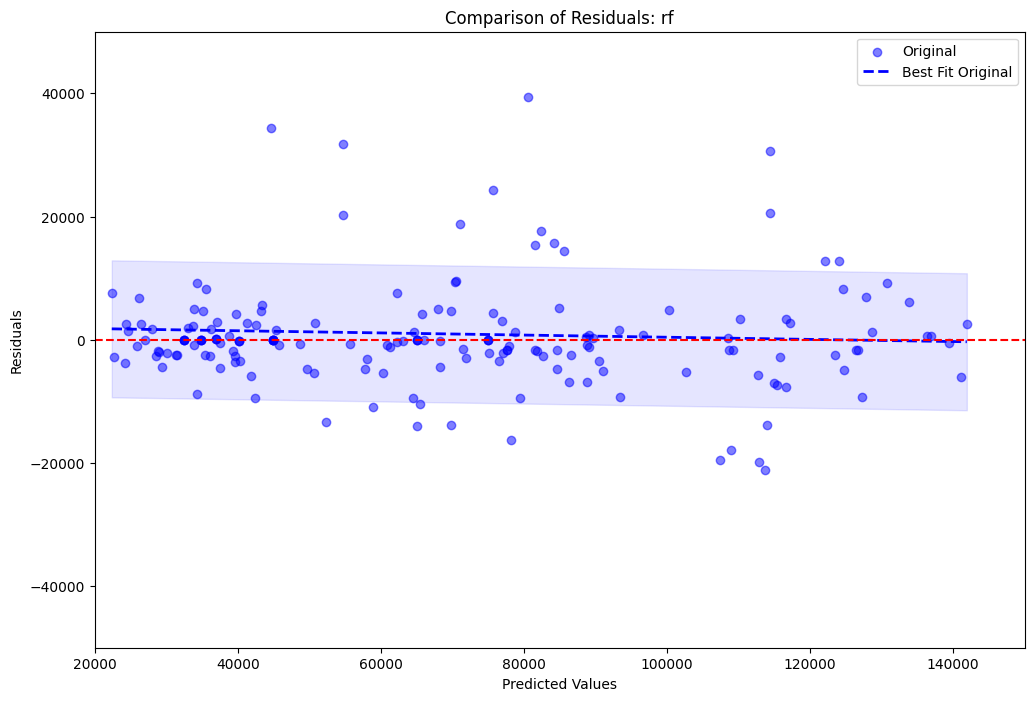

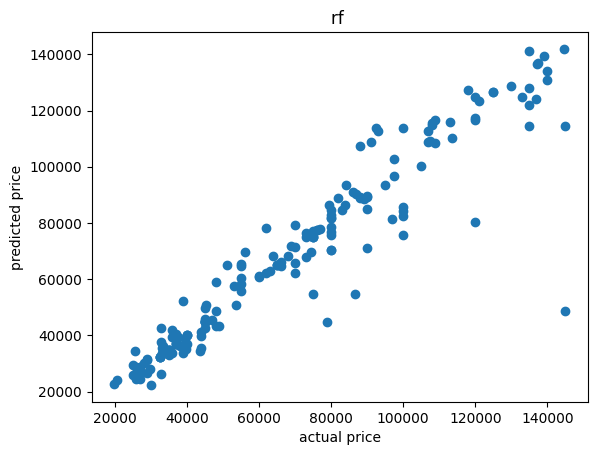

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming y_test, y_pred, y_test_filtered, y_pred_filtered are defined

def calculate_residuals_and_stats(y_test, y_pred):
    """Calculate residuals, predicted values, and stats for given test and prediction arrays."""
    residuals = y_test - y_pred
    predicted = y_pred

    # Calculate and print statistics
    std_residuals = np.std(residuals)
    mean_residuals = np.mean(residuals)
    print(f"STD Residuals: {std_residuals}")
    print(f"MEAN Residuals: {mean_residuals}")

    # Calculate coefficients for the line of best fit
    slope, intercept = np.polyfit(predicted, residuals, 1)
    print("SLOPE", slope)
    line_x = np.linspace(min(predicted), max(predicted), 100)
    line_y = slope * line_x + intercept

    return predicted, residuals, line_x, line_y, std_residuals

# Calculate for both original and filtered datasets
predicted_original, residuals_original, line_x_orig, line_y_orig, std_residuals_orig = calculate_residuals_and_stats(y_test, y_pred)
# predicted_filtered, residuals_filtered, line_x_filt, line_y_filt, std_residuals_filt = calculate_residuals_and_stats(y_test_filtered, y_pred_filtered)

# Plotting
plt.figure(figsize=(12, 8))

# Original dataset residuals
plt.scatter(predicted_original, residuals_original, alpha=0.5, color='blue', label='Original')
plt.plot(line_x_orig, line_y_orig, 'b--', linewidth=2, label='Best Fit Original')
plt.fill_between(line_x_orig, line_y_orig - std_residuals_orig, line_y_orig + std_residuals_orig, color='blue', alpha=0.1)

# Filtered dataset residuals
# plt.scatter(predicted_filtered, residuals_filtered, alpha=0.5, color='green', label='Filtered')
# plt.plot(line_x_filt, line_y_filt, 'g--', linewidth=2, label='Best Fit Filtered')
# plt.fill_between(line_x_filt, line_y_filt - std_residuals_filt, line_y_filt + std_residuals_filt, color='green', alpha=0.1)

plt.title(f'Comparison of Residuals: {model_choice}')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.xlim(20000,150000)
plt.ylim(-50000,50000)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

plt.scatter(y_test, y_pred)
plt.xlabel("actual price")
plt.ylabel("predicted price")
plt.title(f"{model_choice} {fe_str}")
plt.show()



MSE [0.16 1.05 3.99]
pMAE [0.075 0.088 0.078]


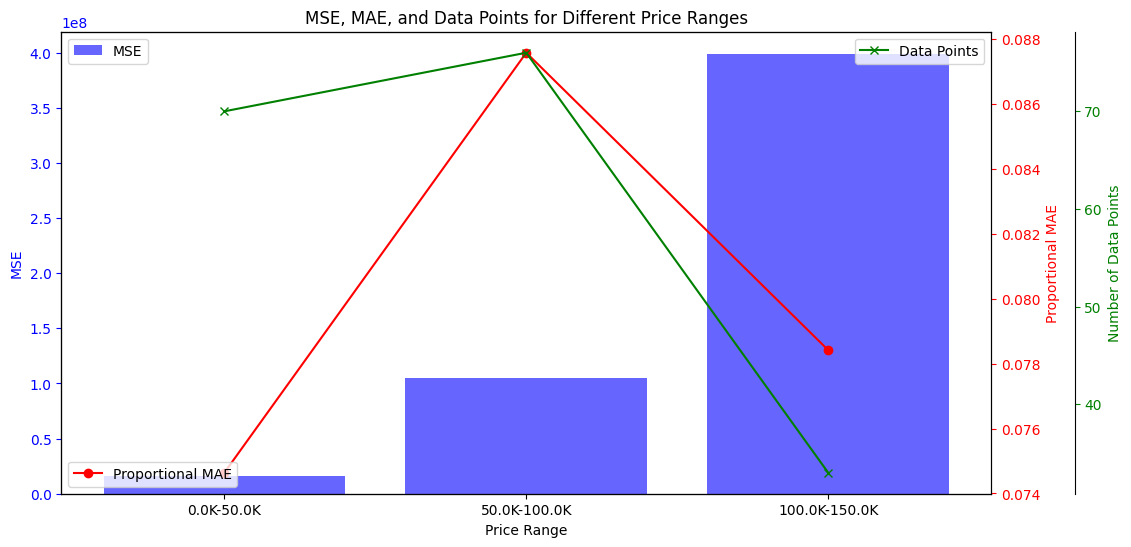

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have y_test and y_pred as your actual and predicted values

# Define your price ranges
# price_categories = [(0, 100000), (100000, 200000), (200000, 300000), 
#                     (300000, 400000), (500000, 600000), (600000, 700000)]
price_categories = [(0, 50000), (50000, 100000), (100000, 150000)]

# Initialize lists to store metrics and evidence count
mse_values = []
mae_values = []
mae_proportional_values = []
evidence_counts = []
price_range_labels = []

for lower, upper in price_categories:
    mask = (y_test >= lower) & (y_test < upper)
    y_test_segment = y_test[mask]
    y_pred_segment = y_pred[mask]

    if len(y_test_segment) > 0:
        # Calculate MSE and MAE for this segment
        mse_values.append(mean_squared_error(y_test_segment, y_pred_segment))
        # mae_values.append(mean_absolute_error(y_test_segment, y_pred_segment))
        mae_value = mean_absolute_error(y_test_segment, y_pred_segment)
        mean_price = np.mean(y_test_segment)
        mae_proportional = mae_value / mean_price  # Proportional MAE
        mae_proportional_values.append(mae_proportional)
        evidence_counts.append(len(y_test_segment))
        price_range_labels.append(f"{lower/1000}K-{upper/1000}K")

# Create subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting MSE
ax1.bar(price_range_labels, mse_values, color='b', alpha=0.6, label='MSE')
ax1.set_xlabel('Price Range')
ax1.set_ylabel('MSE', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for MAE
ax2 = ax1.twinx()
# ax2.plot(price_range_labels, mae_values, color='r', marker='o', label='MAE')
ax2.plot(price_range_labels, mae_proportional_values, color='r', marker='o', label='Proportional MAE')

# ax2.set_ylabel('MAE', color='r')
ax2.set_ylabel('Proportional MAE', color='r')

ax2.tick_params('y', colors='r')

# Creating a third y-axis for Evidence Count
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
ax3.plot(price_range_labels, evidence_counts, color='g', marker='x', label='Data Points')
ax3.set_ylabel('Number of Data Points', color='g')
ax3.tick_params('y', colors='g')

# Title and legends
plt.title('MSE, MAE, and Data Points for Different Price Ranges')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
ax3.legend(loc='upper right')
print("MSE", np.round(np.array(mse_values)/1e8,2))
print("pMAE", np.round(np.array(mae_proportional_values),3))




In [71]:
X_ = np.vstack((X_train, X_test))
Y_ = np.hstack((y_train, y_test))


In [73]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Assuming df is your DataFrame and contains a 'Price' column for the actual prices
# And assuming your features for prediction are ready in df

# Predict prices using the trained model
y_pred = model.predict(X_)


# Calculate the difference between predicted and actual prices
data['Price_Difference'] = Y_ - y_pred
filtered_data = data[abs(data['Price_Difference']) <= 20000]

# Find the 10 most undervalued cars in the filtered dataset
most_undervalued_filtered = filtered_data.sort_values(by='Price_Difference', ascending=True).head(10)

# Find the 10 most overvalued cars in the filtered dataset
most_overvalued_filtered = filtered_data.sort_values(by='Price_Difference', ascending=False).head(10)

# Save the results to CSV files
most_undervalued_filtered.to_csv('most_undervalued_cars.csv', index=False)
most_overvalued_filtered.to_csv('most_overvalued_cars.csv', index=False)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

# Split the data
df = pd.get_dummies(data, drop_first=True)

X = X_combined
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model and optimization function
def rfr_model(n_estimators, max_depth):
    # Model definition
    model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                  max_depth=int(max_depth), 
                                  random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return -mse

# Bayesian optimization
optimizer = BayesianOptimization(
    f=rfr_model,
    pbounds={'n_estimators': (10, 250), 'max_depth': (3, 30)},
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=25)

# Output the optimal parameters
print(optimizer.max)


|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | -1.294e+0 | 14.26     | 182.9     |
| 2         | -2.301e+0 | 3.003     | 82.56     |
| 3         | -1.487e+0 | 6.962     | 32.16     |
| 4         | -1.307e+0 | 8.029     | 92.93     |
| 5         | -1.236e+0 | 13.71     | 139.3     |
| 6         | -1.296e+0 | 14.32     | 174.5     |
| 7         | -1.298e+0 | 8.52      | 220.7     |
| 8         | -2.259e+0 | 3.739     | 170.9     |
| 9         | -1.279e+0 | 14.27     | 144.1     |
| 10        | -1.462e+0 | 6.79      | 57.54     |
| 11        | -1.25e+08 | 20.51     | 178.3     |
| 12        | -1.14e+08 | 12.28     | 100.8     |
| 13        | -2.296e+0 | 3.226     | 103.8     |
| 14        | -1.217e+0 | 14.85     | 95.9      |
| 15        | -1.198e+0 | 18.84     | 103.2     |
| 16        | -1.935e+0 | 4.503     | 141.1     |
| 17        | -1.237e+0 | 21.93     | 140.3     |


KeyboardInterrupt: 